<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Tree-Based Models with Basic Feature Set</h4>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Expanding Training Window](#Inspect-Training-Windows)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Hyperparameter Tuning](#1.1.-Hyperparameter-Tuning)

- [1.2. Testing](#1.2.-Testing)
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

- [2.1. Hyperparameter Tuning](#2.1.-Hyperparameter-Tuning)

- [2.2. Testing](#2.2.-Testing)

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

- [3.1. Hyperparameter Tuning](#3.1.-Hyperparameter-Tuning)

- [3.2. Testing](#3.2.-Testing)

# Setup

[Return to top](#Models)

In [1]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from functools import reduce
import itertools

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
  BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor,
  AdaBoostClassifier, GradientBoostingClassifier
)
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import StackingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import (
  accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score,  
  roc_curve, RocCurveDisplay, auc, average_precision_score, precision_recall_curve, 
  PrecisionRecallDisplay, precision_score, recall_score, f1_score, mean_squared_error
)
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10 ($n$=1222 games). 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09 ($n$=1221 games).
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14 ($n$=729 games so far).

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df = utl.load_and_scale_data(
    file_path='../data/processed/nba_team_matchups_rolling_box_scores_2015_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'], 
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1222 games
Season 2022-23: 1221 games
Season 2023-24: 729 games
Total number of games across sampled seasons: 3172 games


In [22]:
# define number of games in seasons
season_22_games = 1222
season_23_games = 1221

In [3]:
pts_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,TOTAL_PTS
0,0.683,0.638,0.441,0.767,0.372,0.257,0.565,0.500,0.512,0.689,0.395,0.704,0.640,0.508,0.257,0.341,0.269,0.289,0.677,0.640,0.604,0.348,0.637,0.558,0.474,0.614,0.400,0.263,0.701,0.376,0.300,0.297,0.528,0.343,0.308,0.235,0.421,0.586,200.0
1,0.500,0.577,0.565,0.618,0.641,0.464,0.726,0.100,0.031,0.802,0.123,1.000,0.743,0.708,0.324,0.529,0.355,0.145,0.787,0.000,0.180,0.310,0.224,0.000,0.171,0.019,0.148,0.171,0.151,0.412,0.786,0.727,0.000,0.500,0.615,0.565,0.316,0.365,226.0
2,0.575,0.596,0.503,0.676,0.545,0.411,0.650,0.267,0.219,0.774,0.247,0.815,0.657,0.562,0.426,0.353,0.355,0.243,0.733,0.342,0.330,0.278,0.426,0.140,0.238,0.231,0.519,0.457,0.493,0.314,0.750,0.646,0.160,0.500,0.513,0.391,0.368,0.613,229.0
3,0.578,0.500,0.410,0.633,0.534,0.417,0.630,0.444,0.365,0.849,0.350,0.691,0.610,0.514,0.414,0.333,0.319,0.232,0.667,0.486,0.315,0.250,0.430,0.461,0.536,0.436,0.620,0.450,0.758,0.412,0.741,0.689,0.120,0.446,0.462,0.402,0.355,0.716,214.0
4,0.496,0.423,0.356,0.582,0.433,0.366,0.528,0.467,0.414,0.802,0.278,0.565,0.479,0.427,0.443,0.309,0.274,0.342,0.550,0.509,0.514,0.410,0.494,0.621,0.566,0.596,0.230,0.200,0.369,0.494,0.571,0.588,0.384,0.386,0.369,0.217,0.253,0.657,220.0


In [4]:
pm_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,PLUS_MINUS
0,0.683,0.638,0.441,0.767,0.372,0.257,0.565,0.500,0.512,0.689,0.395,0.704,0.640,0.508,0.257,0.341,0.269,0.289,0.677,0.640,0.604,0.348,0.637,0.558,0.474,0.614,0.400,0.263,0.701,0.376,0.300,0.297,0.528,0.343,0.308,0.235,0.421,0.586,26.0
1,0.500,0.577,0.565,0.618,0.641,0.464,0.726,0.100,0.031,0.802,0.123,1.000,0.743,0.708,0.324,0.529,0.355,0.145,0.787,0.000,0.180,0.310,0.224,0.000,0.171,0.019,0.148,0.171,0.151,0.412,0.786,0.727,0.000,0.500,0.615,0.565,0.316,0.365,18.0
2,0.575,0.596,0.503,0.676,0.545,0.411,0.650,0.267,0.219,0.774,0.247,0.815,0.657,0.562,0.426,0.353,0.355,0.243,0.733,0.342,0.330,0.278,0.426,0.140,0.238,0.231,0.519,0.457,0.493,0.314,0.750,0.646,0.160,0.500,0.513,0.391,0.368,0.613,7.0
3,0.578,0.500,0.410,0.633,0.534,0.417,0.630,0.444,0.365,0.849,0.350,0.691,0.610,0.514,0.414,0.333,0.319,0.232,0.667,0.486,0.315,0.250,0.430,0.461,0.536,0.436,0.620,0.450,0.758,0.412,0.741,0.689,0.120,0.446,0.462,0.402,0.355,0.716,-18.0
4,0.496,0.423,0.356,0.582,0.433,0.366,0.528,0.467,0.414,0.802,0.278,0.565,0.479,0.427,0.443,0.309,0.274,0.342,0.550,0.509,0.514,0.410,0.494,0.621,0.566,0.596,0.230,0.200,0.369,0.494,0.571,0.588,0.384,0.386,0.369,0.217,0.253,0.657,20.0


In [5]:
res_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,GAME_RESULT
0,0.683,0.638,0.441,0.767,0.372,0.257,0.565,0.500,0.512,0.689,0.395,0.704,0.640,0.508,0.257,0.341,0.269,0.289,0.677,0.640,0.604,0.348,0.637,0.558,0.474,0.614,0.400,0.263,0.701,0.376,0.300,0.297,0.528,0.343,0.308,0.235,0.421,0.586,1.0
1,0.500,0.577,0.565,0.618,0.641,0.464,0.726,0.100,0.031,0.802,0.123,1.000,0.743,0.708,0.324,0.529,0.355,0.145,0.787,0.000,0.180,0.310,0.224,0.000,0.171,0.019,0.148,0.171,0.151,0.412,0.786,0.727,0.000,0.500,0.615,0.565,0.316,0.365,1.0
2,0.575,0.596,0.503,0.676,0.545,0.411,0.650,0.267,0.219,0.774,0.247,0.815,0.657,0.562,0.426,0.353,0.355,0.243,0.733,0.342,0.330,0.278,0.426,0.140,0.238,0.231,0.519,0.457,0.493,0.314,0.750,0.646,0.160,0.500,0.513,0.391,0.368,0.613,1.0
3,0.578,0.500,0.410,0.633,0.534,0.417,0.630,0.444,0.365,0.849,0.350,0.691,0.610,0.514,0.414,0.333,0.319,0.232,0.667,0.486,0.315,0.250,0.430,0.461,0.536,0.436,0.620,0.450,0.758,0.412,0.741,0.689,0.120,0.446,0.462,0.402,0.355,0.716,0.0
4,0.496,0.423,0.356,0.582,0.433,0.366,0.528,0.467,0.414,0.802,0.278,0.565,0.479,0.427,0.443,0.309,0.274,0.342,0.550,0.509,0.514,0.410,0.494,0.621,0.566,0.596,0.230,0.200,0.369,0.494,0.571,0.588,0.384,0.386,0.369,0.217,0.253,0.657,1.0


# Inspect Expanding Training Window

[Return to top](#Models)

In [6]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, test_size=test_size):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

In [7]:
# expanding window configuration
train_size = 10 # size of training set window
test_size = 1   # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

for train_index, test_index in utl.rolling_window_ts_split(pts_scaled_df, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

Using expanding training window.

<a name="1.1.-Hyperparameter-Tuning"></a>
## 1.1. Hyperparameter Tuning

[Return to top](#Models)

In [ ]:
# configuration for expanding window
initial_train_size = season_22_games # starting size of the training set
expansion_limit = 100     # maximum number of new training observations in expansion
test_size = 1             # leave-one-out (LOO) cross-validation
df = pts_scaled_df        # data set to use
target_col = 'TOTAL_PTS'  # target column name

# constant parameters
constant_params = {
    'random_state': 599,
    'n_jobs': -1,
    'n_estimators': 500
}

# parameters to explore
explore_params = {
    'max_depth': [15, 20, 25],            # tried: 10, 15, 20, 25
    'min_samples_split': [2, 4, 6],       # tried: 2, 4
    'min_samples_leaf': [1, 2],           # tried: 1, 2
    'max_features': [0.3, 0.5],           # tried: 0.3, 0.5
    'min_impurity_decrease': [0.1, 0.3]   # tried: 0.1, 0.3
}

# dict to store results
results = {}

# generate all combinations of hyperparameters to explore
keys, values = zip(*explore_params.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

start_time = time.time()

# iterate over each combination of hyperparameters
for i, explore_param in enumerate(param_combinations):

    print('Parameters currently explored:', explore_param)
    
    # instantiate the model with combined parameters
    model = RandomForestRegressor(**constant_params, **explore_param)
    
    # Assuming utl.train_with_expanding_window is properly defined and imports pts_scaled_df correctly
    model_outputs, y_true = utl.train_with_expanding_window(
        df=df,  
        initial_train_size=initial_train_size, 
        expansion_limit=expansion_limit,
        test_size=test_size,           
        target_col=target_col, 
        model=model
    )
    
    # store outputs and true values in the results dictionary
    results[f"run_{i}"] = {
        "params": {**constant_params, **explore_param},
        "model_outputs": model_outputs,
        "y_true": y_true
    }

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

In [9]:
# get metrics for each combination of parameter values
results_df = utl.compile_results_to_dataframe(results)

# print best hyperparameter settings
results_df.sort_values(by='average_rmse', ascending=True).head()

,run_id,average_rmse,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,n_estimators,n_jobs,random_state
50,run_50,18.444,20,0.5,0.1,1,2,500,-1,599
26,run_26,18.501,15,0.5,0.1,1,2,500,-1,599
25,run_25,18.522,15,0.3,0.3,1,2,500,-1,599
58,run_58,18.523,20,0.5,0.1,1,4,500,-1,599
2,run_2,18.533,10,0.5,0.1,1,2,500,-1,599


<a name="1.2-Testing"></a>
## 1.2 Testing

[Return to top](#Models)

In [14]:
# get best parameters from validation
best_params = get_best_params(results_df, metric='average_rmse')

# configuration for total points with expanding window
initial_train_size = season_22_games + season_23_games # starting size of the training set
expansion_limit = None    # maximum number of new training observations in expansion
test_size = 1             # leave-one-out (LOO) cross-validation
df = pts_scaled_df        # data set to use
target_col = 'TOTAL_PTS'  # target column name

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestRegressor(**best_params)
)

Total time taken: 951.63 seconds


In [15]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.33


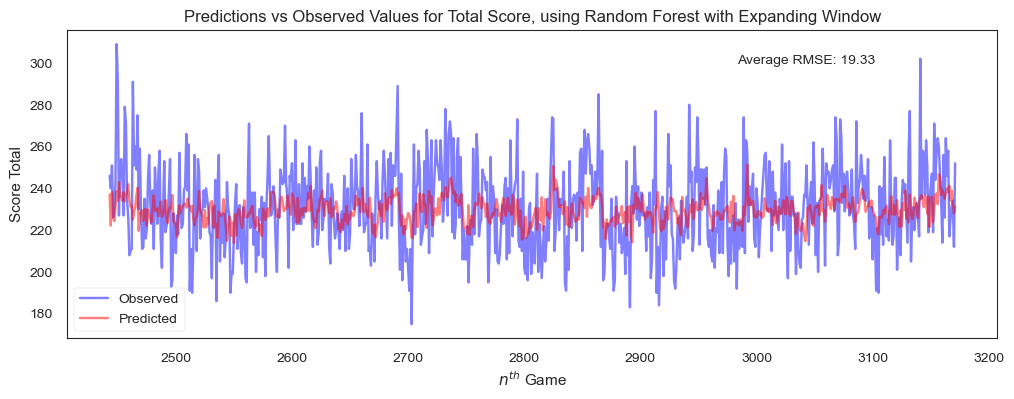

In [18]:
# set end_index based on whether an expansion_limit is specified
if expansion_limit is not None:
    end_index = initial_train_size + expansion_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = initial_train_size + len(model_outputs) * test_size

# adjust the observed_values slice accordingly
observed_values = df[target_col][initial_train_size:end_index]
# ensure lengths are the same (for sanity check)
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Total Score, using Random Forest with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

<a name="2.1.-Hyperparameter-Tuning"></a>
## 2.1. Hyperparameter Tuning

[Return to top](#Models)

In [ ]:
# configuration for expanding window
initial_train_size = season_22_games # starting size of the training set
expansion_limit = 100     # maximum number of new training observations in expansion
test_size = 1             # leave-one-out (LOO) cross-validation
df = pm_scaled_df         # data set to use
target_col = 'PLUS_MINUS' # target column name

# constant parameters
constant_params = {
    'random_state': 599,
    'n_jobs': -1,
    'n_estimators': 500
}

# parameters to explore
explore_params = {
    'max_depth': [15, 20, 25],            # tried: 10, 15, 20, 25
    'min_samples_split': [2, 4, 6],       # tried: 2, 4
    'min_samples_leaf': [1, 2],           # tried: 1, 2
    'max_features': [0.3, 0.5],           # tried: 0.3, 0.5
    'min_impurity_decrease': [0.1, 0.3]   # tried: 0.1, 0.3
}

# dict to store results
results = {}

# generate all combinations of hyperparameters to explore
keys, values = zip(*explore_params.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

start_time = time.time()

# iterate over each combination of hyperparameters
for i, explore_param in enumerate(param_combinations):

    print('Parameters currently explored:', explore_param)
    
    # instantiate the model with combined parameters
    model = RandomForestRegressor(**constant_params, **explore_param)
    
    # Assuming utl.train_with_expanding_window is properly defined and imports pts_scaled_df correctly
    model_outputs, y_true = utl.train_with_expanding_window(
        df=df,  
        initial_train_size=initial_train_size, 
        expansion_limit=expansion_limit,
        test_size=test_size,           
        target_col=target_col, 
        model=model
    )
    
    # store outputs and true values in the results dictionary
    results[f"run_{i}"] = {
        "params": {**constant_params, **explore_param},
        "model_outputs": model_outputs,
        "y_true": y_true
    }

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Parameters currently explored: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'min_impurity_decrease': 0.1}


In [ ]:
# get metrics for each combination of parameter values
results_df = utl.compile_results_to_dataframe(results)

# print best hyperparameter settings
results_df.sort_values(by='average_rmse', ascending=True).head()

<a name="2.2.-Testing"></a>
## 2.2. Testing

[Return to top](#Models)

In [14]:
# get best parameters from validation
best_params = get_best_params(results_df, metric='average_rmse')

# configuration for points difference with expanding window
initial_train_size = season_22_games + season_23_games # starting size of the training set
expansion_limit = None     # maximum number of new training observations in expansion
test_size = 1             # leave-one-out (LOO) cross-validation
df = pm_scaled_df         # data set to use
target_col = 'PLUS_MINUS' # target column name

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestRegressor(**best_params)
)

Total time taken: 232.17 seconds


In [15]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 13.61


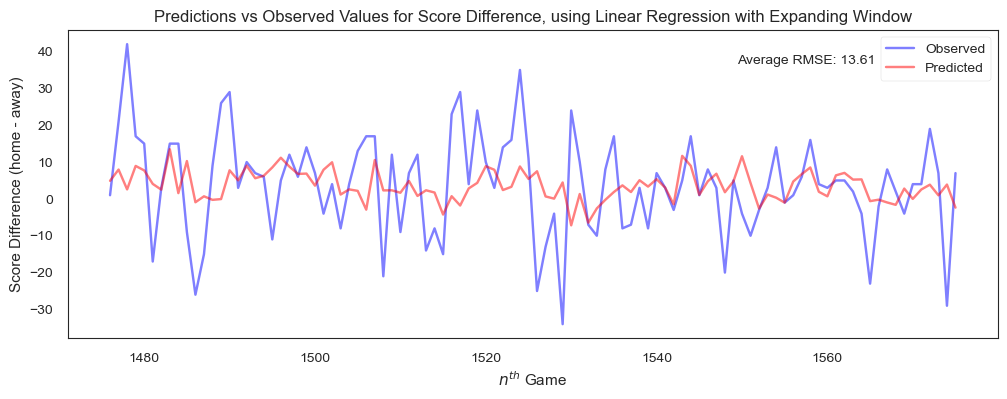

In [16]:
# set end_index based on whether an expansion_limit is specified
if expansion_limit is not None:
    end_index = initial_train_size + expansion_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = initial_train_size + len(model_outputs) * test_size

# adjust the observed_values slice accordingly
observed_values = df[target_col][initial_train_size:end_index]
# ensure lengths are the same (for sanity check)
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Score Difference, using Linear Regression with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Difference (home - away)')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Models)

<a name="3.1.-Hyperparameter-Tuning"></a>
## 3.1. Hyperparameter Tuning

[Return to top](#Models)

In [ ]:
# configuration for expanding window
initial_train_size = season_22_games # starting size of the training set
expansion_limit = 100      # maximum number of new training observations in expansion
test_size = 1              # leave-one-out (LOO) cross-validation
df = res_scaled_df         # data set to use
target_col = 'GAME_RESULT' # target column name

# constant parameters
constant_params = {
    'random_state': 599,
    'n_jobs': -1,
    'n_estimators': 500,
    'max_features': ['sqrt']
}

# parameters to explore
explore_params = {
    'criterion': ['gini', 'entropy'],     # tried: 'gini', 'entropy'
    'max_depth': [15, 20, 25],            # tried: 10, 15, 20, 25
    'min_samples_split': [2, 4, 6],       # tried: 2, 4
    'min_samples_leaf': [1, 2],           # tried: 1, 2
    'min_impurity_decrease': [0.1, 0.3]   # tried: 0.1, 0.3
}

# dict to store results
results = {}

# generate all combinations of hyperparameters to explore
keys, values = zip(*explore_params.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

start_time = time.time()

# iterate over each combination of hyperparameters
for i, explore_param in enumerate(param_combinations):

    print('Parameters currently explored:', explore_param)
    
    # instantiate the model with combined parameters
    model = RandomForestClassifier(**constant_params, **explore_param)
    
    # Assuming utl.train_with_expanding_window is properly defined and imports pts_scaled_df correctly
    model_outputs, y_true = utl.train_with_expanding_window(
        df=df,  
        initial_train_size=initial_train_size, 
        expansion_limit=expansion_limit,
        test_size=test_size,           
        target_col=target_col, 
        model=model
    )
    
    # store outputs and true values in the results dictionary
    results[f"run_{i}"] = {
        "params": {**constant_params, **explore_param},
        "model_outputs": model_outputs,
        "y_true": y_true
    }

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

In [ ]:
# get metrics for each combination of parameter values
results_df = utl.compile_results_to_dataframe(results)

# print best hyperparameter settings
results_df.sort_values(by='average_accuracy', ascending=True).head()

<a name="3.2.-Testing"></a>
## 3.2. Testing

[Return to top](#Models)

In [20]:
# get best parameters from validation
best_params = get_best_params(results_df, metric='average_accuracy')

# configuration for game winner with expanding window
initial_train_size = season_22_games + season_23_games  # starting size of the training set
expansion_limit = None      # maximum number of new training observations in expansion
test_size = 1               # leave-one-out (LOO) cross-validation
df = res_scaled_df          # data set to use
target_col = 'GAME_RESULT'  # target column name

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestClassifier(**best_params),
    ensure_diversity=True # ensure class diversity in training
)

Total time taken: 33.89 seconds


In [21]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.59
- Overall AUC: 0.59
- Average F1 Score: 0.71


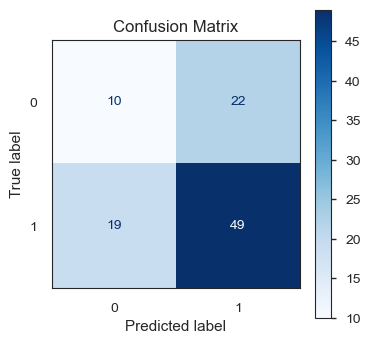

In [22]:
# calculate confusion matrix
cm = confusion_matrix(y_true, metrics['pred_labels'])

# plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix');

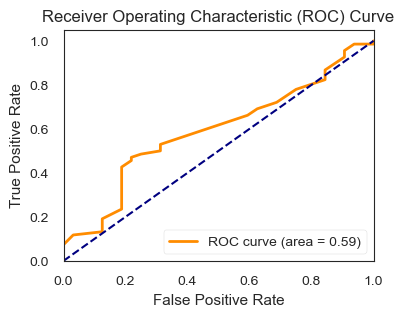

In [23]:
# calculate FPR (False Positive Rate), TPR (True Positive Rate), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, model_outputs)

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");